IMPORTS, VERSION AND GPU CHECK

In [1]:
!python --version
# to free up the ram of GPU
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

Python 3.9.13


In [2]:

# import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)


import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
import tensorflow as tf
# from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')
tf.test.is_built_with_cuda()
# device_lib.list_local_devices()
# !pip install keras_cv_attention_models

/home/system9-user4/anaconda3/envs/shivani/bin/python
3.9.13 (main, Aug 25 2022, 23:26:10) 
[GCC 11.2.0]
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)


2023-03-09 17:22:17.949837: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-09 17:22:29.973586: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-09 17:22:30.028491: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-09 17:22:30.223486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA Quadro P5000 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 269.00GiB/s
2023-03-09 17:22:30.223671: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-09 17:22:30.816834: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


True

In [3]:
import tensorflow

In [4]:
from platform import python_version

print(python_version())

import tensorflow as tf
print(tf. __version__)

import tensorflow as tf
# from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

!python --version
import tensorflow as tf
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

3.9.13
2.4.1
Num GPUs Available:  1
Python 3.9.13
Num GPUs Available 1


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
#from .. import keras_cv_attention_models 
from keras_cv_attention_models.attention_layers import (
    batchnorm_with_activation,
    conv2d_no_bias,
    depthwise_conv2d_no_bias,
    drop_block,
    layer_norm,
    output_block,
    MultiHeadRelativePositionalEmbedding,
    add_pre_post_process,
)
from keras_cv_attention_models.download_and_load import reload_model_weights

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from tensorflow.keras import Input
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.layers import Concatenate
import preprocess_crop
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input


/home/system9-user4/anaconda3/envs/shivani/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
print(tf.version.VERSION)

2.4.1


CMT CODE WITH PROPOSED MODIFICATION

In [7]:
PRETRAINED_DICT = {"cmt_tiny": {"imagenet": {160: "cb269248643e9d50d8bea051563e20a6", 224: "d0f2f0cf649a7aea48a1a4e3a476606c"}}}

In [8]:
def light_mhsa_with_multi_head_relative_position_embedding(
    inputs, num_heads=4, key_dim=0, sr_ratio=1, out_shape=None, out_weight=True, out_bias=False, attn_dropout=0, name=""
):
    _, hh, ww, cc = inputs.shape
    key_dim = key_dim if key_dim > 0 else cc // num_heads
    qk_scale = float(1.0 / tf.math.sqrt(tf.cast(key_dim, "float32")))
    out_shape = cc if out_shape is None or not out_weight else out_shape
    emb_dim = num_heads * key_dim

    query = keras.layers.Dense(emb_dim, use_bias=False, name=name and name + "query")(inputs) * qk_scale
    # print(f">>>> {inputs.shape = }, {query.shape = }, {sr_ratio = }")
    # query = [batch, num_heads, hh * ww, key_dim]
    query = tf.transpose(tf.reshape(query, [-1, inputs.shape[1] * inputs.shape[2], num_heads, key_dim]), [0, 2, 1, 3])

    if sr_ratio > 1:
        key_value = depthwise_conv2d_no_bias(inputs, kernel_size=sr_ratio, strides=sr_ratio, name=name + "kv_sr_")
        key_value = layer_norm(key_value, name=name + "kv_sr_")
        # key_value = keras.layers.AvgPool2D(sr_ratio, strides=sr_ratio, name=name + "kv_sr_")(inputs)
    else:
        key_value = inputs
    # key_value = [batch, num_heads, hh, ww, kv_kernel * kv_kernel, key_dim * 2]
    key_value = keras.layers.Dense(emb_dim * 2, use_bias=False, name=name and name + "key_value")(key_value)
    # key_value = conv2d_no_bias(inputs, emb_dim * 2, kernel_size=sr_ratio, strides=sr_ratio, use_bias=False, name=name + "key_value")
    _, kv_hh, kv_ww, _ = key_value.shape
    # print(f">>>> {key_value.shape = }")

    # dim, head, kv
    key_value = tf.reshape(key_value, [-1, kv_hh * kv_ww, key_dim, num_heads, 2])
    key = tf.transpose(key_value[:, :, :, :, 0], [0, 3, 2, 1])  # [batch, num_heads, key_dim, hh * ww]
    value = tf.transpose(key_value[:, :, :, :, 1], [0, 3, 1, 2])  # [batch, num_heads, hh * ww, key_dim]
    # kv, head, dim
    # key, value = tf.split(key_value, 2, axis=-1)
    # key = tf.transpose(tf.reshape(key, [-1, kv_hh * kv_ww, num_heads, key_dim]), [0, 2, 3, 1]) # [batch, num_heads, key_dim, hh * ww]
    # value = tf.transpose(tf.reshape(value, [-1, kv_hh * kv_ww, num_heads, key_dim]), [0, 2, 1, 3]) # [batch, num_heads, hh * ww, key_dim]

    # print(f">>>> {attn_query.shape = }, {key.shape = }, {value.shape = }, {kv_inp.shape = }, {pos_query.shape = }")
    # attention_scores = [batch, num_heads, hh * ww, kv_hh * kv_ww]
    attention_scores = keras.layers.Lambda(lambda xx: tf.matmul(xx[0], xx[1]))([query, key])
    attention_scores = MultiHeadRelativePositionalEmbedding(with_cls_token=False, attn_height=hh, name=name and name + "pos_emb")(attention_scores)
    attention_scores = keras.layers.Softmax(axis=-1, name=name and name + "attention_scores")(attention_scores)

    if attn_dropout > 0:
        attention_scores = keras.layers.Dropout(attn_dropout, name=name and name + "attn_drop")(attention_scores)
    # value = [batch, num_heads, key_hh * key_ww, key_dim]
    attention_output = keras.layers.Lambda(lambda xx: tf.matmul(xx[0], xx[1]))([attention_scores, value])
    attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
    attention_output = tf.reshape(attention_output, [-1, inputs.shape[1], inputs.shape[2], num_heads * key_dim])
    # print(f">>>> {attention_output.shape = }, {attention_scores.shape = }")

    if out_weight:
        # [batch, hh, ww, num_heads * key_dim] * [num_heads * key_dim, out] --> [batch, hh, ww, out]
        attention_output = keras.layers.Dense(out_shape, use_bias=out_bias, name=name and name + "output")(attention_output)
    return attention_output

In [9]:
def inverted_residual_feed_forward(inputs, expansion=4, activation="gelu", name=""):
    """ IRFFN(X) = Conv(F(Conv(X))), F(X) = DWConv(X) + X """
    in_channel = inputs.shape[-1]
    expanded = conv2d_no_bias(inputs, int(in_channel * expansion), kernel_size=1, use_bias=True, name=name + "1_")
    expanded = batchnorm_with_activation(expanded, activation=activation, act_first=True, name=name + "1_")

    dw = depthwise_conv2d_no_bias(expanded, kernel_size=3, padding="SAME", use_bias=True, name=name)
    dw = keras.layers.Add(name=name + "dw_add")([expanded, dw])
    dw = batchnorm_with_activation(dw, activation=activation, act_first=True, name=name + "2_")

    pw = conv2d_no_bias(dw, in_channel, kernel_size=1, use_bias=True, name=name + "3_")
    pw = batchnorm_with_activation(pw, activation=None, name=name + "3_")
    return pw

In [10]:


def cmt_block(inputs, num_heads=4, sr_ratio=1, expansion=4, activation="gelu", drop_rate=0, name=""):
    """ X0 = LPU(Xi), X1 = LMHSA(LN(X0)) + X0, X2 = IRFFN(LN(X1)) + X1 """
    """ Local Perception Unit, LPU(X) = DWConv(X) + X """
    lpu = depthwise_conv2d_no_bias(inputs, kernel_size=3, padding="SAME", use_bias=True, name=name)
    # lpu = batchnorm_with_activation(lpu, activation=activation, name=name + "lpu_", act_first=True)
    lpu_out = keras.layers.Add(name=name + "lpu_out")([inputs, lpu])
    print("lpu_out : ",lpu_out.shape)
    """ light multi head self attention """
    attn = layer_norm(lpu_out, name=name + "attn_")
    attn = light_mhsa_with_multi_head_relative_position_embedding(attn, num_heads=num_heads, sr_ratio=sr_ratio, name=name + "light_mhsa_")
    attn_out = keras.layers.Add(name=name + "attn_out")([lpu_out, attn])
    print("attn_out : ",attn_out.shape)
    #x = Conv2D(3, (3, 3), padding='same')(input)
   
    """ inverted residual feed forward """
    ffn = layer_norm(attn_out, name=name + "ffn_")
    ffn = inverted_residual_feed_forward(ffn, expansion=expansion, activation=activation, name=name + "ffn_")
    ffn = drop_block(ffn, drop_rate=drop_rate)
    ffn_out = keras.layers.Add(name=name + "ffn_output")([attn_out, ffn])
    print("ffn_out :",ffn_out.shape)
    print("cmt_block -----------------------------------------------------------------------------------------------------------")
    return ffn_out

In [11]:
def cmt_stem(inputs, stem_width, activation="gelu", name="", **kwargs):
    nn = conv2d_no_bias(inputs, stem_width, kernel_size=3, strides=2, padding="same", use_bias=True, name=name + "1_")
    nn = batchnorm_with_activation(nn, activation=activation, act_first=True, name=name + "1_")
    nn = conv2d_no_bias(nn, stem_width, kernel_size=3, strides=1, padding="same", use_bias=True, name=name + "2_")
    nn = batchnorm_with_activation(nn, activation=activation, act_first=True, name=name + "2_")
    nn = conv2d_no_bias(nn, stem_width, kernel_size=3, strides=1, padding="same", use_bias=True, name=name + "3_")
    nn = batchnorm_with_activation(nn, activation=activation, act_first=True, name=name + "3_")
    return nn

In [12]:

def CMT(
    num_blocks,
    out_channels,
    stem_width=16,
    num_heads=[1, 2, 4, 8],
    sr_ratios=[8, 4, 2, 1],
    ffn_expansion=4,
    input_shape=(224, 224, 3),
    num_classes=1000,
    activation="gelu",
    drop_connect_rate=0,
    classifier_activation="softmax",
    output_num_features=1024,
    dropout=0,
    pretrained=None,
    model_name="cmt",
    kwargs=None,
    flag=0
):
    inputs = keras.layers.Input(input_shape)
    nn = cmt_stem(inputs, stem_width=stem_width, activation=activation, name="stem_"+flag)
    print("After cmt stem ",nn.shape)
    """ stage [1, 2, 3, 4] """
    total_blocks = sum(num_blocks)
    global_block_id = 0
    for stack_id, (num_block, out_channel, num_head, sr_ratio) in enumerate(zip(num_blocks, out_channels, num_heads, sr_ratios)):
        stage_name = "stack{}_".format(stack_id + 1)
        nn = conv2d_no_bias(nn, out_channel, kernel_size=2, strides=2, use_bias=True, name=stage_name + "down_sample"+flag)
        nn = layer_norm(nn, name=stage_name+flag)
        print("Before entering cmt block chain ",nn.shape)

        for block_id in range(num_block):
            name = stage_name + "block{}_".format(block_id + 1)
            block_drop_rate = drop_connect_rate * global_block_id / total_blocks
            global_block_id += 1
            nn = cmt_block(nn, num_head, sr_ratio, ffn_expansion, activation=activation, drop_rate=block_drop_rate, name=name+flag)
            print("After stage ",block_id," shape ",nn.shape)
    nn = output_block(nn, output_num_features, activation, num_classes, dropout, classifier_activation, act_first=True)
    print("After output block ",nn.shape)
    model = keras.models.Model(inputs, nn, name=model_name+flag)
    add_pre_post_process(model, rescale_mode="torch")
    reload_model_weights(model, PRETRAINED_DICT, "cmt", pretrained, MultiHeadRelativePositionalEmbedding)
    
    return model

In [13]:
def CMTTiny(flag,input_shape=(160, 160, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained="imagenet", **kwargs):
    if flag=='1':
      num_blocks = [2, 2, 10, 2]
    num_blocks = [2, 2, 10, 2]
    out_channels = [46, 92, 184, 368]
    stem_width = 16
    ffn_expansion = 3.6
    return CMT(**locals(), model_name="cmt_tiny", **kwargs)

In [14]:
def CMTXS(input_shape=(192, 192, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained=None, **kwargs):
    num_blocks = [3, 3, 12, 3]
    out_channels = [52, 104, 208, 416]
    stem_width = 16
    ffn_expansion = 3.8
    return CMT(**locals(), model_name="cmt_xs", **kwargs)

In [15]:
def CMTSmall(flag,input_shape=(224, 224, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained=None, **kwargs):
    print("hello Fuction CMT Small called")
    if flag=='1':
        num_blocks = [2,3,4,5]
    else:
        num_blocks = [3, 3, 16, 3]
    out_channels = [64, 128, 256, 512]
    stem_width = 32
    ffn_expansion = 4
    return CMT(**locals(), model_name="cmt_small2", **kwargs)

In [16]:
def CMTBig(input_shape=(256, 256, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained=None, **kwargs):
    num_blocks = [4, 4, 20, 4]
    out_channels = [76, 152, 304, 608]
    stem_width = 38
    ffn_expansion = 4
    return CMT(**locals(), model_name="cmt_big", **kwargs)

IMPORTS AND DATA PREPARATION

In [17]:
print(cv2. __version__)

4.5.5


In [18]:
disease_types=['COVID', 'non-COVID']


data_dir_224 = '/home/system9-user4/CMT_PROJECT/Dataset_split/fol_orig/k_fold/train2345'
val_data_dir_224='/home/system9-user4/CMT_PROJECT/Dataset_split/fol_orig/k_fold/val1'
test_data_dir_224='/home/system9-user4/CMT_PROJECT/Dataset_split/fol_orig/split_224_train_test/test'

train_dir = os.path.join(data_dir_224)
test_dir = os.path.join(test_data_dir_224)
val_dir = os.path.join(val_data_dir_224)

print(train_dir)
print(test_dir)
print(val_dir)

/home/system9-user4/CMT_PROJECT/Dataset_split/fol_orig/k_fold/train2345
/home/system9-user4/CMT_PROJECT/Dataset_split/fol_orig/split_224_train_test/test
/home/system9-user4/CMT_PROJECT/Dataset_split/fol_orig/k_fold/val1


In [19]:
# train dataframe
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

print(train.head())


print()
# val dataframe
val_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(val_dir, sp)):
        val_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
val = pd.DataFrame(val_data, columns=['File', 'DiseaseID','Disease Type'])

print(val.head())
print()
# test dataframe
test_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(test_dir, sp)):
        test_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
test = pd.DataFrame(test_data, columns=['File', 'DiseaseID','Disease Type'])

print(test.head())


                     File  DiseaseID Disease Type
0   COVID/Covid (132).png          0        COVID
1  COVID/Covid (1104).png          0        COVID
2   COVID/Covid (407).png          0        COVID
3   COVID/Covid (950).png          0        COVID
4   COVID/Covid (248).png          0        COVID

                    File  DiseaseID Disease Type
0  COVID/Covid (560).png          0        COVID
1  COVID/Covid (289).png          0        COVID
2  COVID/Covid (905).png          0        COVID
3  COVID/Covid (563).png          0        COVID
4  COVID/Covid (692).png          0        COVID

                    File  DiseaseID Disease Type
0  COVID/Covid (226).png          0        COVID
1  COVID/Covid (308).png          0        COVID
2  COVID/Covid (502).png          0        COVID
3  COVID/Covid (319).png          0        COVID
4  COVID/Covid (770).png          0        COVID


In [20]:
SEED = 2
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

test = test.sample(frac=1, random_state=SEED) 
test.index = np.arange(len(test)) # Reset indices
test.head()


val = val.sample(frac=1, random_state=SEED) 
val.index = np.arange(len(val)) # Reset indices
val.head()




,File,DiseaseID,Disease Type
0,COVID/Covid (4).png,0,COVID
1,COVID/Covid (72).png,0,COVID
2,non-COVID/Non-Covid (384).png,1,non-COVID
3,COVID/Covid (274).png,0,COVID
4,non-COVID/Non-Covid (1017).png,1,non-COVID


In [21]:
IMAGE_SIZE = 224
# IMAGE_SIZE = 160

def read_image(fol_type,filepath):
    return cv2.imread(os.path.join(fol_type, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [22]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

file_map={}
# key=image vector value=filepath
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(data_dir_224,file)
    # img=read_image()
    if image is not None:
        X_train[i] = image
        # X_train[i] = resize_image(image,(IMAGE_SIZE,IMAGE_SIZE))
        X_train[i]=X_train[i]/255.
        file_map[data_dir_224+file]=X_train[i]

# Normalize the data
# X_Train = X_train
print('Train Shape: {}'.format(X_train.shape))
# print(file_map)


X_test = np.zeros((test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))


# key=image vector value=filepath
for i, file in tqdm(enumerate(test['File'].values)):
    image = read_image(test_data_dir_224,file)
    # img=read_image()
    if image is not None:
        X_test[i] = image
        # X_test[i] = resize_image(image,image_size=(IMAGE_SIZE,IMAGE_SIZE))
        X_test[i]=X_test[i]/255.
        file_map[test_data_dir_224+file]=X_test[i]

# Normalize the data
# X_Train = X_train
print('Test Shape: {}'.format(X_test.shape))
# print(file_map)


X_val = np.zeros((val.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

# key=image vector value=filepath
for i, file in tqdm(enumerate(val['File'].values)):
    image = read_image(val_data_dir_224,file)
    # img=read_image()
    if image is not None:
        X_val[i] = image
        # X_val[i] = resize_image(image,image_size=(IMAGE_SIZE,IMAGE_SIZE))

        X_val[i]=X_val[i]/255.
        file_map[val_data_dir_224+file]=X_val[i]

# Normalize the data
# X_Train = X_train
print('Val Shape: {}'.format(X_val.shape))
# print(file_map)




1586it [00:08, 194.57it/s]


Train Shape: (1586, 224, 224, 3)


497it [00:02, 232.30it/s]


Test Shape: (497, 224, 224, 3)


398it [00:01, 243.60it/s]

Val Shape: (398, 224, 224, 3)


In [23]:
Y_train = train['DiseaseID'].values
Y_test = test['DiseaseID'].values
Y_val = val['DiseaseID'].values

Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)
Y_val = to_categorical(Y_val, num_classes=2)

In [24]:
BATCH_SIZE = 32

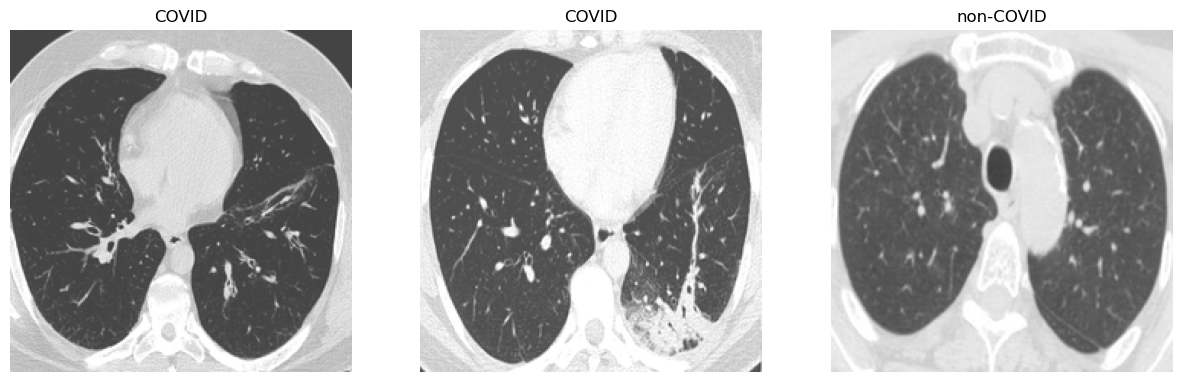

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    # plt.imshow((X_train[i] * 255).astype(np.uint8))
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [26]:
EPOCHS = 80
SIZE=224
# SIZE=160
N_ch=3

TRAINING-MODEL FUNCTIONS

In [27]:
input = Input(shape=(224, 224, N_ch))
    
densenet = DenseNet169(weights='imagenet', include_top=False)



2023-03-09 17:23:02.547312: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 17:23:02.549948: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-09 17:23:02.552222: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA Quadro P5000 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 269.00GiB/s
2023-03-09 17:23:02.552297: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-09 17:23:02.552359: I tensorflow/stream_executor/platfo

In [28]:
cmtt_par = CMTSmall(flag='1',num_classes=0,pretrained=None)
cmtt_par.summary()

cmtt_parl = Sequential(cmtt_par)
cmtt_parl.summary()

# cmtt_par1 = CMTSmall(flag='2',num_classes=0,pretrained=None)
# cmtt_par1.summary()
# cmtt_parl1 = Sequential(cmtt_par1)
# cmtt_parl1.summary()



hello Fuction CMT Small called
After cmt stem  (None, 112, 112, 32)
Before entering cmt block chain  (None, 56, 56, 64)
lpu_out :  (None, 56, 56, 64)
attn_out :  (None, 56, 56, 64)
ffn_out : (None, 56, 56, 64)
cmt_block -----------------------------------------------------------------------------------------------------------
After stage  0  shape  (None, 56, 56, 64)
lpu_out :  (None, 56, 56, 64)
attn_out :  (None, 56, 56, 64)
ffn_out : (None, 56, 56, 64)
cmt_block -----------------------------------------------------------------------------------------------------------
After stage  1  shape  (None, 56, 56, 64)
Before entering cmt block chain  (None, 28, 28, 128)
lpu_out :  (None, 28, 28, 128)
attn_out :  (None, 28, 28, 128)
ffn_out : (None, 28, 28, 128)
cmt_block -----------------------------------------------------------------------------------------------------------
After stage  0  shape  (None, 28, 28, 128)
lpu_out :  (None, 28, 28, 128)
attn_out :  (None, 28, 28, 128)
ffn_out : 

In [29]:
def cmt_dense_wideNet():
    
    input = Input(shape=(SIZE, SIZE, N_ch))
    
    dnet = densenet(input) #passing input through densenet 1
    print(dnet.shape)
    cmtt1 = cmtt_parl(input) #passing input through cmtsmall 2
    
    #  concatenating 1 and 2
    x =  Concatenate()([dnet,cmtt1])
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
    
    
    return model

In [30]:
model = cmt_dense_wideNet()
model.summary()

(None, 7, 7, 1664)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet169 (Functional)        (None, None, None, 1 12642880    input_4[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 7, 7, 1024)   21282720    input_4[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 7, 7, 2688)   0           densenet169[0][0]                
                                                                 sequential

: 

In [58]:
BATCH_SIZE = 16
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
mstr='v2_d1_80_fold5_cmts2345_d169'
checkpoint = ModelCheckpoint(mstr+'.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation


datagen = ImageDataGenerator(
                        # rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.4, # Range for random horizontal shifts
                        height_shift_range=0.4, # Range for random vertical shifts
                        zoom_range=0.4, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        # vertical_flip=True
                        ) # Randomly flip inputs vertically


datagen.fit(X_train)  #note the copy

# Fits the model on batches with real-time data augmentation

hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=80,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val,Y_val))

/home/system9-user4/anaconda3/envs/shivani/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-03-07 16:49:12.560432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-07 16:49:12.579933: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


Epoch 1/80


2023-03-07 16:49:40.473761: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-07 16:49:40.715657: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


99/99 - 100s - loss: 0.9324 - accuracy: 0.5732 - val_loss: 0.7037 - val_accuracy: 0.5427

Epoch 00001: val_loss improved from inf to 0.70366, saving model to v2_d1_80_fold5_cmts2345_r50.h5
Epoch 2/80
99/99 - 65s - loss: 0.7580 - accuracy: 0.6452 - val_loss: 0.6384 - val_accuracy: 0.5653

Epoch 00002: val_loss improved from 0.70366 to 0.63838, saving model to v2_d1_80_fold5_cmts2345_r50.h5
Epoch 3/80
99/99 - 65s - loss: 0.5973 - accuracy: 0.7197 - val_loss: 0.5424 - val_accuracy: 0.7688

Epoch 00003: val_loss improved from 0.63838 to 0.54243, saving model to v2_d1_80_fold5_cmts2345_r50.h5
Epoch 4/80
99/99 - 62s - loss: 0.5050 - accuracy: 0.7669 - val_loss: 0.8101 - val_accuracy: 0.5050

Epoch 00004: val_loss did not improve from 0.54243
Epoch 5/80
99/99 - 59s - loss: 0.4535 - accuracy: 0.7885 - val_loss: 0.4976 - val_accuracy: 0.7839

Epoch 00005: val_loss improved from 0.54243 to 0.49757, saving model to v2_d1_80_fold5_cmts2345_r50.h5
Epoch 6/80
99/99 - 59s - loss: 0.4356 - accuracy: 0

In [67]:
np.save(mstr+'.npy', hist.history)

EVALUATION

In [70]:
print(model.evaluate(X_test, Y_test))

16/16 [==============================] - 5s 302ms/step - loss: 0.0676 - accuracy: 0.9718
[0.06758607923984528, 0.9718309640884399]


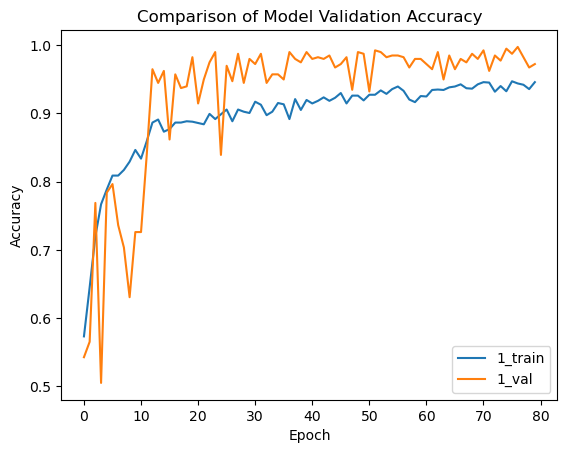

In [71]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
# plt.plot(model['accuracy'])
# plt.plot(model['val_accuracy'])
# plt.plot(model['accuracy'])
# plt.plot(model['val_accuracy'])


# plt.plot(final_accuracy)
plt.title('Comparison of Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['1_train','1_val'], loc='lower right')
# plt.legend(['DenseNet169','CMTS2345','CMTS2345_DenseNet169'], loc='lower right')
# plt.show()
# plt.savefig('d1_val_accuracy_plt.eps',format='eps')

# loss plot


Text(0.5, 192.72222222222217, 'Predicted')

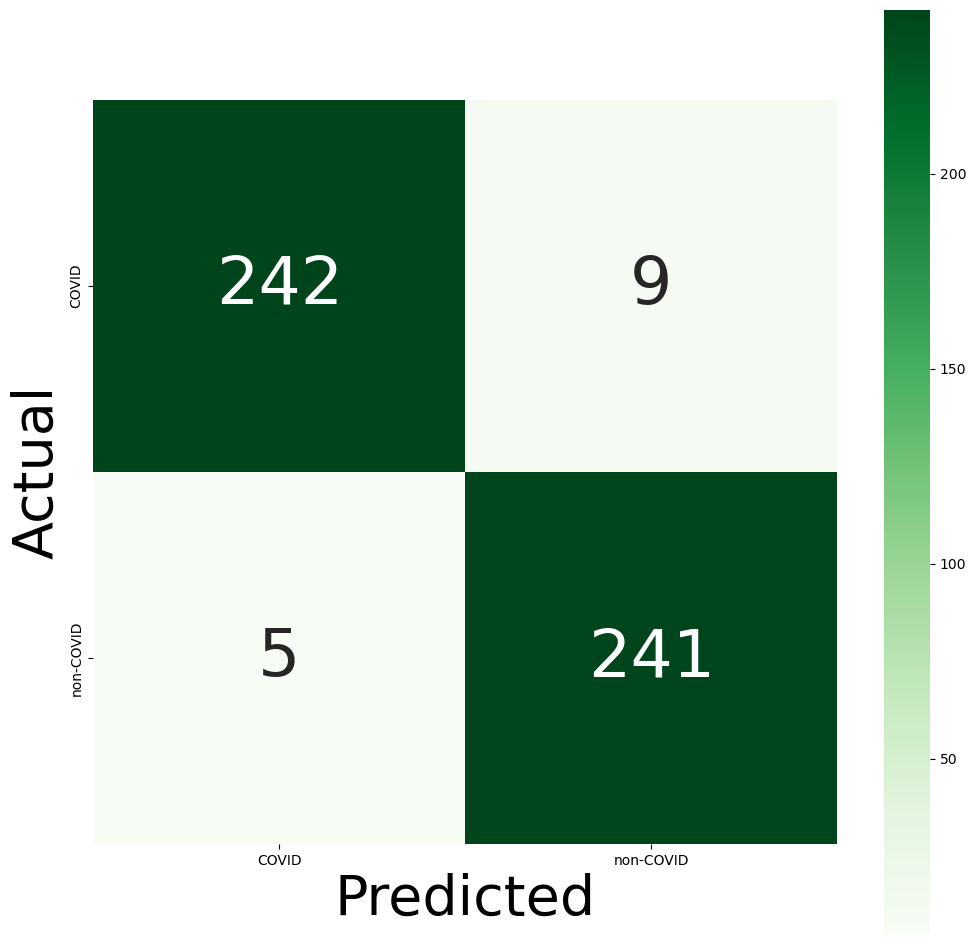

In [72]:

Y_pred = model.predict(X_test)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
# cm.savefig(mstr+"_cm.png")
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types,fmt=".0f",annot_kws={"size": 48})

ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)


In [73]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred, labels=None, target_names=None, sample_weight=None, digits=4, output_dict=False, zero_division='warn'))


              precision    recall  f1-score   support

           0     0.9798    0.9641    0.9719       251
           1     0.9640    0.9797    0.9718       246

    accuracy                         0.9718       497
   macro avg     0.9719    0.9719    0.9718       497
weighted avg     0.9720    0.9718    0.9718       497



In [74]:

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', format(sensitivity,".4f"))

specificity = cm[1,1]/(cm[1,0]+cm[1,1])

print('Specificity : ', format(specificity,".4f"))

Sensitivity :  0.9641
Specificity :  0.9797
